# More LCEL practice

Alright enough games, let's talk data. One usecase that LLM can solve is to handle data formatting. Let's say we want to build a scrapper that:

- Scrape a given HTML page
- Structure that HTML into a structured json
- Then that json is processed as a pandas dataframe

For this exercise, we will build an application that will collect financial data from companies so that we can compare them later on.

Ready 🌶️ Let's go 💨


### Step 0 - Demo setup

For this demo to run, we advise you to:

1. Run a docker container with the following image:

```bash
docker run -v $(pwd):/home/jovyan -p 8888:8888 jupyter/datascience-notebook
```

2. Then install the following libraries:


In [ ]:
# If that's not the case, don't forget to install the following libraries
# !pip install langchain -q
# !pip install langchain-community -q 
# !pip install langchain_mistralai -q
# !pip install langserve -q
# !pip install langgraph -q
# !pip install transformers -q
# !pip install --upgrade typing_extensions -q
# !pip install grandalf -q
# !pip install bs4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [bs4]


## Step I - Collect raw data

As a first step, we want to collect raw data from the wikipedia website.

1. Write a Python function that uses the `requests` library to send an HTTP GET request to Apple's wikipedia page. Ensure the request includes headers such as a User-Agent to specify which web browser will be emulated to send the request.


In [2]:
import requests
from bs4 import BeautifulSoup

url = "https://en.wikipedia.org/wiki/Apple_Inc."

# Create a session to store cookies
session = requests.Session()

# Set User-Agent
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36"
}

# Make the request with the headers
resp = session.get(url, headers=headers)

if resp.status_code == 200:
    print(f"Successfully got the content of {url}")
else:
    print(f"Error: {resp.status_code}")

Successfully got the content of https://en.wikipedia.org/wiki/Apple_Inc.


2. Use BeautifulSoup to parse and extract all `table` tags with class `infobox` from the request's result.


In [3]:
# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(resp.text, "html.parser")

# Find all tables in the HTML
tables = soup.find_all("table", class_="infobox")

# Extract the HTML content of each table
table_contents = [str(table) for table in tables]

table_contents

['<table class="infobox ib-company vcard"><caption class="infobox-title fn org" style="font-size: 125%;">Apple Inc.</caption><tbody><tr><td class="infobox-image ib-company-logo logo" colspan="2"><span class="mw-default-size skin-invert" typeof="mw:File/Frameless"><a class="mw-file-description" href="/wiki/File:Apple_logo_black.svg"><img class="mw-file-element" data-file-height="1000" data-file-width="814" decoding="async" height="135" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Apple_logo_black.svg/120px-Apple_logo_black.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Apple_logo_black.svg/250px-Apple_logo_black.svg.png 1.5x" width="110"/></a></span><div class="infobox-caption"><a class="mw-redirect" href="/wiki/Apple_logo" title="Apple logo">Apple logo</a> used since 1998</div></td></tr><tr><td class="infobox-image ib-company-logo logo" colspan="2"><span class="mw-default-size" typeof="mw:File/Frameless"><a class="mw-file-description" href="/wiki/File:

3. Using `langchain_core.runnables.chain`, create a scraper function you'll turn into a chain so that it can be invoked with an input URL and return the extracted table data as output. Then test it on some example url.

<Note type="tip">

To turn a function into a chainable, use the @chain decorator

</Note>


In [4]:
from langchain_core.runnables import chain


@chain
def scraper(url: str):

    # Create a session to store cookies
    session = requests.Session()

    # Set User-Agent
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36"
    }

    # Make the request with the headers
    resp = session.get(url, headers=headers)

    if resp.status_code == 200:
        print(f"Successfully got the content of {url}")
    else:
        print(f"Error: {resp.status_code}")
        return None

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(resp.text, "html.parser")

    # Find all tables in the HTML
    tables = soup.find_all("table", class_="infobox")

    # Extract the HTML content of each table
    table_contents = [str(table) for table in tables]

    # Return the list of table HTML contents
    return table_contents

In [5]:
scraper.invoke("https://en.wikipedia.org/wiki/Apple_Inc")

Successfully got the content of https://en.wikipedia.org/wiki/Apple_Inc


['<table class="infobox ib-company vcard"><caption class="infobox-title fn org" style="font-size: 125%;">Apple Inc.</caption><tbody><tr><td class="infobox-image ib-company-logo logo" colspan="2"><span class="mw-default-size skin-invert" typeof="mw:File/Frameless"><a class="mw-file-description" href="/wiki/File:Apple_logo_black.svg"><img class="mw-file-element" data-file-height="1000" data-file-width="814" decoding="async" height="135" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Apple_logo_black.svg/120px-Apple_logo_black.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Apple_logo_black.svg/250px-Apple_logo_black.svg.png 1.5x" width="110"/></a></span><div class="infobox-caption"><a class="mw-redirect" href="/wiki/Apple_logo" title="Apple logo">Apple logo</a> used since 1998</div></td></tr><tr><td class="infobox-image ib-company-logo logo" colspan="2"><span class="mw-default-size" typeof="mw:File/Frameless"><a class="mw-file-description" href="/wiki/File:

## Step II - Create your system prompt

Okay we have our HTML content. Now let's create our applicaton. First, let's create our system prompt:

Create a `ChatPromptTemplate` that will tell the model to extract key information about the company while handling missing values or unavailability. Test the template on something basic for now like "hello world".


In [7]:
from langchain_core.prompts import ChatPromptTemplate

# Prompt string
sys_prompt = """
Parse the given HTML content to extract 
all useful information in a structure json format

I want: 

* The name of the company 
* Date of foundation 
* Name of the founders 
* sector 
* This year's revenu 
* Net income 
* Total assets 

If some data is not available simply write "N/A" and ONLY output the JSON format.

Here is the content:

```html 
{content}
```
"""

# Define system prompt
template = ChatPromptTemplate.from_messages([("system", sys_prompt)])

# Let's output something
# This is useless for the moment
dict(template.invoke({"content": "<html><h1>hello world!</h1>"}))

{'messages': [SystemMessage(content='\nParse the given HTML content to extract \nall useful information in a structure json format\n\nI want: \n\n* The name of the company \n* Date of foundation \n* Name of the founders \n* sector \n* This year\'s revenu \n* Net income \n* Total assets \n\nIf some data is not available simply write "N/A" and ONLY output the JSON format.\n\nHere is the content:\n\n```html \n<html><h1>hello world!</h1>\n```\n', additional_kwargs={}, response_metadata={})]}

## Step III - Create the model

Now you need to create the model.

Instanciate a mistral model (start small, and go bigger when your code is fully functional), and test it on some greeting prompt.


In [9]:
# Don't forget your API Key
#%env MISTRAL_API_KEY=

```

In [10]:
from langchain_mistralai import ChatMistralAI

# Let's instanciate a model 
model = ChatMistralAI(model="mistral-large-latest")

# let's output something
model.invoke( "Say hi to my Jedha students!")

AIMessage(content="Hello to all the Jedha students! I hope you're doing well and ready to learn.", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 11, 'total_tokens': 32, 'completion_tokens': 21}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run--b122306c-47f8-431b-a326-f12afcefa744-0', usage_metadata={'input_tokens': 11, 'output_tokens': 21, 'total_tokens': 32})

## Step IV - Create a chainable function

Now finally let's create a chainable function that accepts a json as input, and outputs a pandas dataframe. The output dataframe should be appended to a csv file called `company_info.csv`

The function should be able to handle the following exception: _The input is not a valid json_.

<Note type="tip">

To turn a function into a chainable, use the @chain decorator

</Note>


In [11]:
import pandas as pd
import os
import json


@chain
def process_json_to_csv(input_data, file_name="company_info.csv"):

    print(f"Received text data: {input_data}")
    # This blocks parse an AIMessage() type of data
    try:
        json_content = input_data.content
        parsed_json = (
            json_content.replace("```json", "")
            .replace("```", "")
            .replace("\\n", "")
            .replace("\\", "")
        )
        input_data = json.loads(parsed_json)
    except json.JSONDecodeError:
        print("Error: The model output is not valid JSON.")
        return None

    # Step 2: Convert the input into a pandas DataFrame
    if isinstance(input_data, dict):
        df = pd.DataFrame([input_data])  # Assuming the input is a dict
    else:
        print("Error: Input data is not a valid structure for DataFrame.")
        return None

    # Step 3: Check if the CSV file exists
    file_exists = os.path.isfile(file_name)

    # Step 4: Append the DataFrame to the CSV file
    df.to_csv(file_name, mode="a", header=not file_exists, index=False)

    # Step 5: Return the DataFrame
    return df

## Step V - Chained it all together

Alright now let's bring all the pieces together, create a chain that will take a URL as input and output all the information in a `company_info.csv` file.


In [12]:
from langchain_core.runnables import RunnablePassthrough


app = scraper | template | model | process_json_to_csv

app.invoke(
    "https://en.wikipedia.org/wiki/Apple_Inc.", {"content": RunnablePassthrough()}
)

Successfully got the content of https://en.wikipedia.org/wiki/Apple_Inc.
Received text data: content='```json\n{\n  "company_name": "Apple Inc.",\n  "date_of_foundation": "April 1, 1976",\n  "founders": ["Steve Jobs", "Steve Wozniak", "Ronald Wayne"],\n  "sector": ["Consumer electronics", "Software services", "Online services"],\n  "this_years_revenu": "US$391 billion",\n  "net_income": "US$94 billion",\n  "total_assets": "US$365 billion"\n}\n```' additional_kwargs={} response_metadata={'token_usage': {'prompt_tokens': 6319, 'total_tokens': 6460, 'completion_tokens': 141}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'} id='run--b69fe9d3-57d1-455e-9c2a-d5394002d2f7-0' usage_metadata={'input_tokens': 6319, 'output_tokens': 141, 'total_tokens': 6460}


,company_name,date_of_foundation,founders,sector,this_years_revenu,net_income,total_assets
0,Apple Inc.,"April 1, 1976","[Steve Jobs, Steve Wozniak, Ronald Wayne]","[Consumer electronics, Software services, Onli...",US$391 billion,US$94 billion,US$365 billion


## Step V - BONUS - Visualize your chain

If you want to visualize your whole chain, you can run: `chain.get_graph().print_ascii()` 🎨


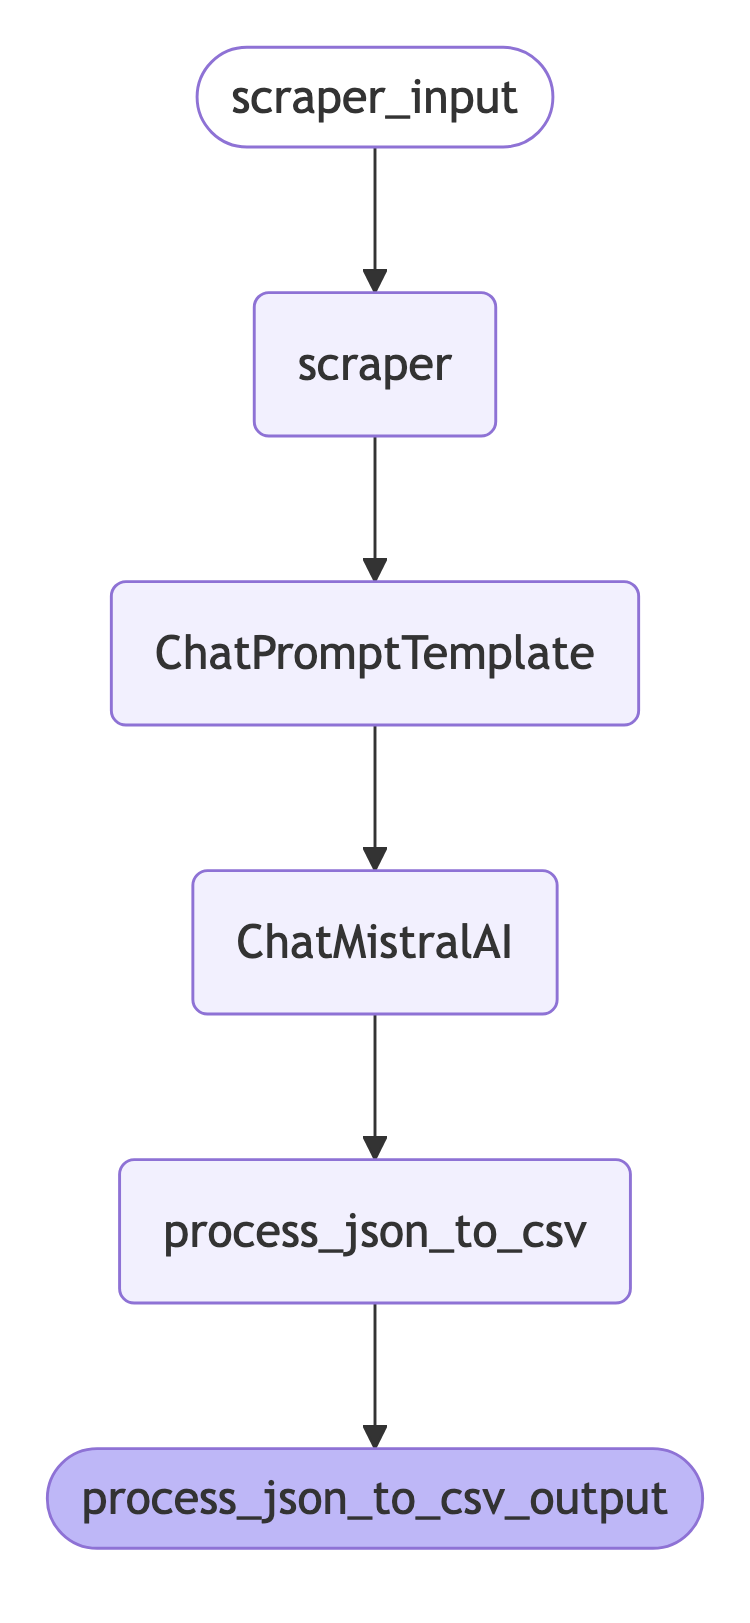

In [16]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
import nest_asyncio

nest_asyncio.apply()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER,
        )
    )
)

In [13]:
app.get_graph().print_ascii()

      +---------------+        
      | scraper_input |        
      +---------------+        
               *               
               *               
               *               
          +---------+          
          | scraper |          
          +---------+          
               *               
               *               
               *               
    +--------------------+     
    | ChatPromptTemplate |     
    +--------------------+     
               *               
               *               
               *               
      +---------------+        
      | ChatMistralAI |        
      +---------------+        
               *               
               *               
               *               
    +---------------------+    
    | process_json_to_csv |    
    +---------------------+    
               *               
               *               
               *               
+----------------------------+ 
| proces